# Классификация знаков Дорожного Движения

In [1]:
# !pip install natsort

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from skimage import transform

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.compat.v1.config.experimental.list_physical_devices("GPU") else "OFF" }')


import numpy as np
import matplotlib, random
import matplotlib.pyplot as plt
import pandas as pd 
import cv2
import os

from imutils import paths
import os
import pathlib
import LRFinder
from natsort import natsorted

Tensorflow version 2.10.0
GPU is ON


In [3]:
data = []
labels = []
sumu =0
start = 0
input_size = (60,60)
path = "./New_Dataset/information_signs/"
num_classes = len(os.listdir(path))
for file_number in os.listdir(path):
    path2 = str(path+file_number)
    num = 0
    count=0
    for file_number_2 in os.listdir(path2):
        path3 = str(path2 + '/' + file_number_2)
#         if count == 320: break
        count = count+1
        imagepath = (path3)
#         print(imagepath)
        image = cv2.imread(imagepath, 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image = transform.resize(image, input_size)
        data.append(image)

        label = file_number
        labels.append(label)
    num = num + count
    sumu = sumu+count
    print(label, num)
print('all',sumu)

148 173
149 281
150 353
151 245
152 1037
153 209
154 677
155 245
156 1361
157 1109
158 281
159 1073
160 173
161 533
162 677
163 281
164 605
all 9313


In [4]:
df = pd.DataFrame({'labels': labels})
print(df.nunique())
print(df['labels'].value_counts())

labels    17
dtype: int64
156    1361
157    1109
159    1073
152    1037
154     677
162     677
164     605
161     533
150     353
149     281
158     281
163     281
155     245
151     245
153     209
160     173
148     173
Name: labels, dtype: int64


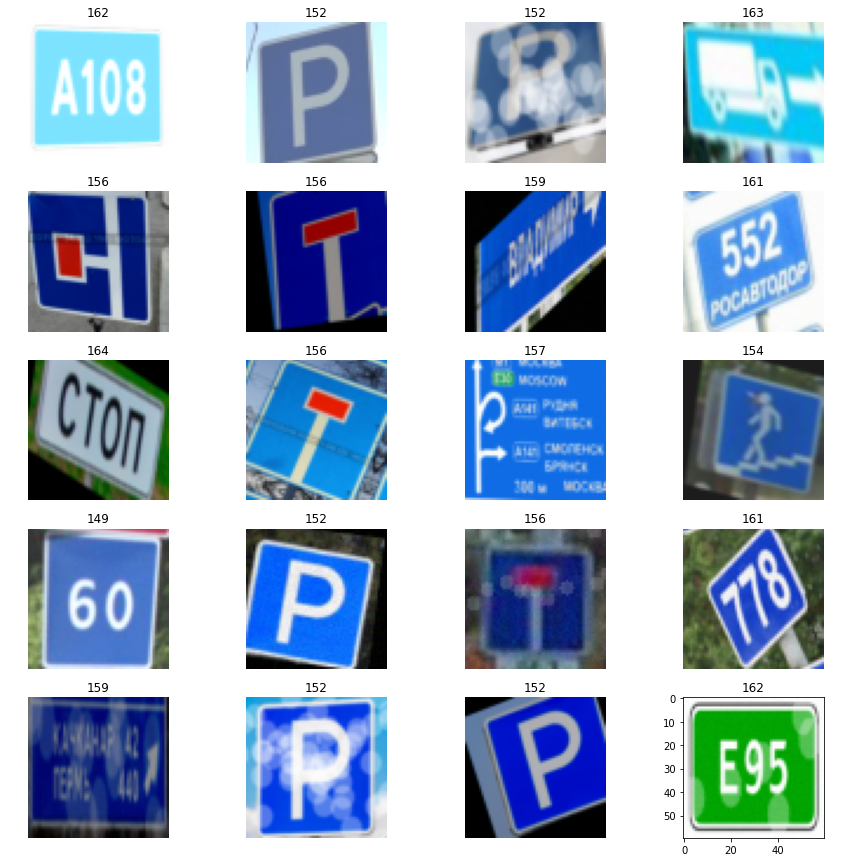

In [5]:
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    z = random.randint(1,len(labels))
    plt.axis('off') 
    fig.add_subplot(rows, columns, i)
    plt.title(labels[z])
    plt.imshow(data[z])
plt.show()

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state = 42, test_size = 0.3, stratify = labels)

from keras.utils import to_categorical
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [7]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D,UpSampling2D,ZeroPadding2D, Dense, Flatten, Dropout, BatchNormalization , Input, ReLU
from keras import initializers
import math
import tensorflow_addons as tfa

from keras.optimizers import SGD, Adam

opt = SGD(learning_rate=0.008)
# opt = Adam(learning_rate=0.0001)
# opt = SGD()
initializer = initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512), seed=42)

model = Sequential()
model.add(Input(shape=np.array(X_train).shape[1:]))

# model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=32, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.05))

model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=64, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.1))

# model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=128, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.15))

# model.add(ZeroPadding2D(padding=2))
model.add(Conv2D(filters=256, kernel_size=5, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.2))

model.add(BatchNormalization (momentum=0.9, epsilon=1e-5))


model.add(Flatten()) # по кол-ву пикселей из 2д в 1д
model.add(Dense(128, activation='swish')) # кол-во нейронов в слое
model.add(Dense(64, activation='swish')) # кол-во нейронов в слое
model.add(Dense(32, activation='swish')) # кол-во нейронов в слое
model.add(Dense(num_classes, kernel_initializer=initializer, bias_initializer=initializer, activation='softmax'))  # кол-во нейронов на выходе, по кол-ву классов


model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics=tfa.metrics.F1Score(num_classes=num_classes))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 29, 29, 32)        0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0

In [8]:
# lr_finder = LRFinder.LRFinder(model)
# lr_finder.find(np.array(X_train), np.array(y_train), start_lr=0.00001, end_lr=1, batch_size=10, epochs=20)
# lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

In [9]:
history = model.fit(np.array(X_train), np.array(y_train), batch_size=10, epochs=50, validation_data=(np.array(X_test), np.array(y_test)))

Epoch 1/50
652/652 [==============================] - 30s 42ms/step - loss: 2.4643 - f1_score: 0.1016 - val_loss: 1.9519 - val_f1_score: 0.1733
Epoch 2/50
652/652 [==============================] - 16s 24ms/step - loss: 1.5512 - f1_score: 0.2726 - val_loss: 1.1063 - val_f1_score: 0.3695
Epoch 3/50
652/652 [==============================] - 16s 24ms/step - loss: 1.0184 - f1_score: 0.4845 - val_loss: 0.6337 - val_f1_score: 0.7295
Epoch 4/50
652/652 [==============================] - 16s 25ms/step - loss: 0.6251 - f1_score: 0.7283 - val_loss: 0.4237 - val_f1_score: 0.8080
Epoch 5/50
652/652 [==============================] - 16s 25ms/step - loss: 0.4322 - f1_score: 0.8169 - val_loss: 0.2336 - val_f1_score: 0.8809
Epoch 6/50
652/652 [==============================] - 16s 24ms/step - loss: 0.3058 - f1_score: 0.8717 - val_loss: 0.2566 - val_f1_score: 0.9161
Epoch 7/50
652/652 [==============================] - 16s 24ms/step - loss: 0.2280 - f1_score: 0.9153 - val_loss: 0.1784 - val_f1_score:

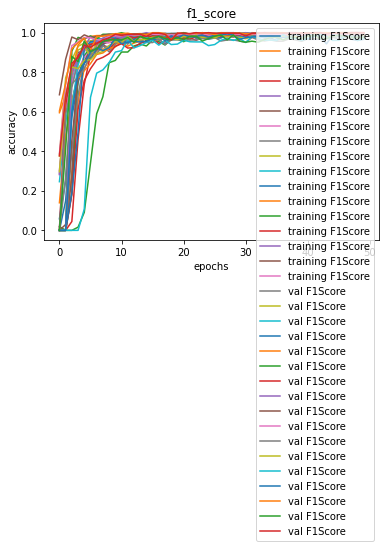

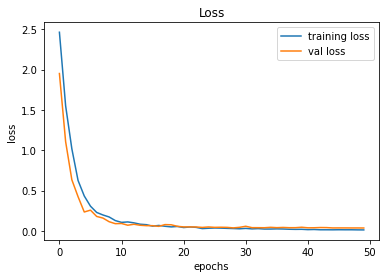

In [10]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['f1_score'], label='training F1Score')
plt.plot(history.history['val_f1_score'], label='val F1Score')
plt.title('f1_score')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [17]:
# model.save('./saved_models/Trafic_Signs_CNN_inf_signs.h5')

In [12]:
inf_signs_classes = {'0':148,
'1':149,
'2':150,
'3':151,
'4':152,
'5':153,
'6':154,
'7':155,
'8':156,
'9':157,
'10':158,
'11':159,
'12':160,
'13':161,
'14':162,
'15':163,
'16':164,}

In [13]:
from sklearn.metrics import f1_score
df = pd.read_csv('./Data_images/Test_data.csv')
all_classes = []
predicted_classes = []
for c in range (148, 164):
    for i in range(60):
        
        all_classes.append(c)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
        classid = df.loc[df['ClassId'] == c].values[i][0]
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(inf_signs_classes[str(prediction[0])])
        
        if classid != inf_signs_classes[(str(prediction[0]))]:
             print(classid,inf_signs_classes[(str(prediction[0]))], prediction[0], image_path)


1/1 [==============================] - 0s 15ms/step
148 159 11 Test/148_6_14.png
1/1 [==============================] - 0s 15ms/step
149 159 11 Test/149_3_30.png
1/1 [==============================] - 0s 16ms/step
149 161 13 Test/149_6_32.png
1/1 [==============================] - 0s 17ms/step
149 159 11 Test/149_6_21.png
1/1 [==============================] - 0s 16ms/step
149 161 13 Test/149_6_11.png
1/1 [==============================] - 0s 17ms/step
149 157 9 Test/149_1_25.png
1/1 [==============================] - 0s 16ms/step
149 161 13 Test/149_6_22.png
1/1 [==============================] - 0s 16ms/step
150 161 13 Test/150_2_11.png
1/1 [==============================] - 0s 16ms/step
150 159 11 Test/150_5_9.png
1/1 [==============================] - 0s 18ms/step
150 159 11 Test/150_5_1.png
1/1 [==============================] - 0s 15ms/step
150 152 4 Test/150_5_29.png
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
150 159 11 Test/150_5_21.png
1/1 [==============================] - 0s 15ms/step
150 159 11 Test/150_5_20.png
1/1 [==============================] - 0s 17ms/step
150 159 11 Test/150_5_13.png
1/1 [==============================] - 0s 19ms/step
151 152 4 Test/151_2_9.png
1/1 [==============================] - 0s 15ms/step
151 152 4 Test/151_1_9.png
1/1 [==============================] - 0s 16ms/step
151 150 2 Test/151_1_11.png
1/1 [==============================] - 0s 16ms/step
151 152 4 Test/151_2_18.png
1/1 [==============================] - 0s 15ms/step
151 152 4 Test/151_3_17.png
1/1 [==============================] - 0s 16ms/step
151 161 13 Test/151_3_2.png
1/1 [==============================] - 0s 16ms/step
151 161 13 Test/151_3_12.png
1/1 [==============================] - 0s 16ms/step
151 152 4 Test/151_4_30.png
1/1 [==============================] - 0s 16ms/step
152 154 6 Test/152_3_4.png
1/1 [==============================] - 

153 152 4 Test/153_4_10.png
1/1 [==============================] - 0s 16ms/step
154 161 13 Test/154_1_0.png
1/1 [==============================] - 0s 16ms/step
154 161 13 Test/154_1_24.png
1/1 [==============================] - 0s 16ms/step
154 161 13 Test/154_1_19.png
1/1 [==============================] - 0s 15ms/step
154 150 2 Test/154_6_29.png
1/1 [==============================] - 0s 15ms/step
154 159 11 Test/154_5_19.png
1/1 [==============================] - 0s 15ms/step
154 161 13 Test/154_1_29.png
1/1 [==============================] - 0s 16ms/step
154 152 4 Test/154_4_22.png
1/1 [==============================] - 0s 15ms/step
154 161 13 Test/154_6_10.png
1/1 [==============================] - 0s 16ms/step
154 152 4 Test/154_4_38.png
1/1 [==============================] - 0s 17ms/step
154 161 13 Test/154_4_5.png
1/1 [==============================] - 0s 18ms/step
154 159 11 Test/154_3_38.png
1/1 [==============================] - 0s 16ms/step
154 159 11 Test/154_4_26.png
1/1 [

1/1 [==============================] - 0s 16ms/step
155 161 13 Test/155_5_20.png
1/1 [==============================] - 0s 16ms/step
155 161 13 Test/155_1_10.png
1/1 [==============================] - 0s 16ms/step
155 154 6 Test/155_7_22.png
1/1 [==============================] - 0s 16ms/step
155 161 13 Test/155_2_24.png
1/1 [==============================] - 0s 16ms/step
155 159 11 Test/155_1_32.png
1/1 [==============================] - 0s 16ms/step
156 149 1 Test/156_2_4.png
1/1 [==============================] - 0s 15ms/step
156 161 13 Test/156_4_2.png
1/1 [==============================] - 0s 16ms/step
156 150 2 Test/156_4_25.png
1/1 [==============================] - 0s 16ms/step
156 159 11 Test/156_4_5.png
1/1 [==============================] - 0s 16ms/step
156 159 11 Test/156_1_17.png
1/1 [==============================] - 0s 15ms/step
156 159 11 Test/156_4_18.png
1/1 [==============================] - 0s 15ms/step
157 159 11 Test/157_1_20.png
1/1 [=============================

1/1 [==============================] - 0s 16ms/step
158 164 16 Test/158_3_28.png
1/1 [==============================] - 0s 15ms/step
158 161 13 Test/158_3_16.png
1/1 [==============================] - 0s 15ms/step
158 163 15 Test/158_1_21.png
1/1 [==============================] - 0s 15ms/step
158 159 11 Test/158_7_37.png
1/1 [==============================] - 0s 16ms/step
158 159 11 Test/158_5_2.png
1/1 [==============================] - 0s 15ms/step
158 164 16 Test/158_3_2.png
1/1 [==============================] - 0s 16ms/step
158 164 16 Test/158_3_11.png
1/1 [==============================] - 0s 16ms/step
158 159 11 Test/158_3_38.png
1/1 [==============================] - 0s 16ms/step
158 161 13 Test/158_3_29.png
1/1 [==============================] - 0s 16ms/step
159 161 13 Test/159_4_5.png
1/1 [==============================] - 0s 16ms/step
160 159 11 Test/160_1_8.png
1/1 [==============================] - 0s 16ms/step
160 159 11 Test/160_6_28.png
1/1 [===========================

1/1 [==============================] - 0s 18ms/step
160 159 11 Test/160_6_14.png
1/1 [==============================] - 0s 16ms/step
160 159 11 Test/160_6_0.png
1/1 [==============================] - 0s 16ms/step
160 159 11 Test/160_5_27.png
1/1 [==============================] - 0s 18ms/step
160 159 11 Test/160_6_36.png
1/1 [==============================] - 0s 17ms/step
160 159 11 Test/160_3_16.png
1/1 [==============================] - 0s 17ms/step
161 164 16 Test/161_7_2.png
1/1 [==============================] - 0s 19ms/step
161 164 16 Test/161_1_16.png
1/1 [==============================] - 0s 16ms/step
161 164 16 Test/161_1_13.png
1/1 [==============================] - 0s 16ms/step
161 164 16 Test/161_1_36.png
1/1 [==============================] - 0s 15ms/step
161 164 16 Test/161_1_18.png
1/1 [==============================] - 0s 16ms/step
162 159 11 Test/162_6_5.png
1/1 [==============================] - 0s 16ms/step
162 161 13 Test/162_5_13.png
1/1 [==========================

1/1 [==============================] - 0s 16ms/step
162 159 11 Test/162_5_25.png
1/1 [==============================] - 0s 15ms/step
163 159 11 Test/163_2_17.png
1/1 [==============================] - 0s 16ms/step
163 159 11 Test/163_7_16.png
1/1 [==============================] - 0s 16ms/step
163 159 11 Test/163_7_29.png
1/1 [==============================] - 0s 16ms/step
163 159 11 Test/163_4_0.png
1/1 [==============================] - 0s 16ms/step
163 159 11 Test/163_4_20.png
1/1 [==============================] - 0s 15ms/step
163 159 11 Test/163_7_14.png
1/1 [==============================] - 0s 16ms/step


In [14]:
print (f1_score(all_classes, predicted_classes, average='weighted'))

0.9079666971288168


Text(0.5, 0.98, 'Plot of confusion matrix')

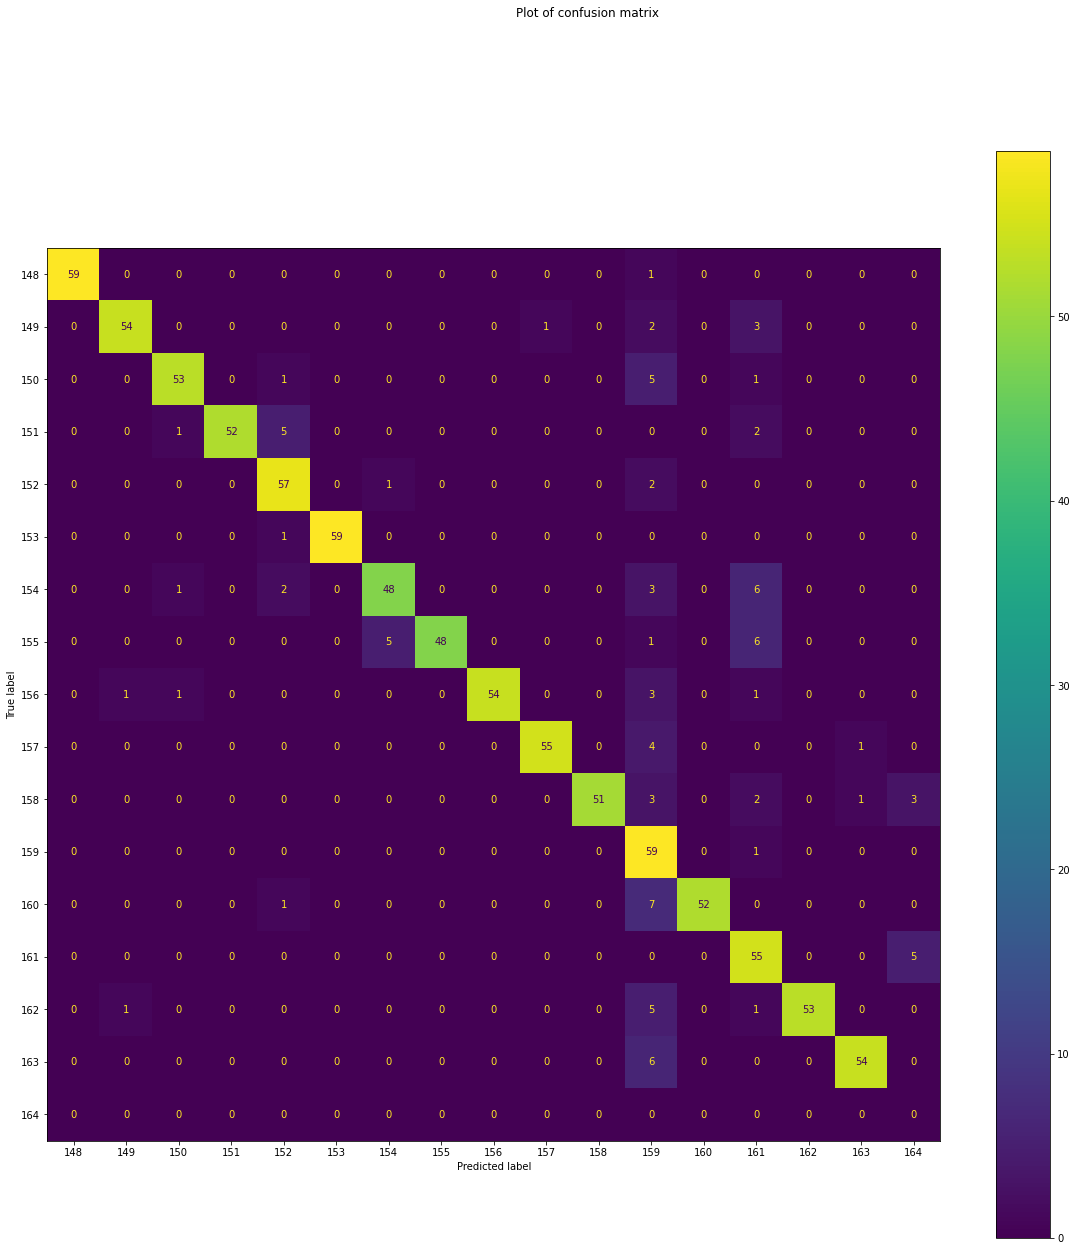

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
display = ConfusionMatrixDisplay.from_predictions(all_classes, predicted_classes)
fig = display.figure_
fig.set_figwidth(20)
fig.set_figheight(20) 
fig.suptitle('Plot of confusion matrix')